<a href="https://colab.research.google.com/github/ryanleeks/fake-job-detection/blob/main/BERT_Fusion_LLRD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Fake Job Detection — **Text + Tabular Fusion** with **LLRD** and **Focal Loss**

This notebook upgrades a DistilBERT baseline by:
- **Fusing text** (`[CLS]` embedding) **with tabular features** (lengths, binaries, categoricals).
- Using **Layer-wise Learning Rate Decay (LLRD)** for stable/efficient fine-tuning.
- Handling class imbalance via **Focal Loss** with **class-balanced α**.
- **Threshold tuning** to maximize **F1 for the fraud class**.
- Saving a **reproducible checkpoint** with the **tabular metadata** (feature order + scaler + dummies).

> ⚠️ Make sure you’re running where Hugging Face models can be downloaded (e.g., Colab).


In [13]:

# === Setup ===
import os, re, math, pickle, random, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from transformers import (
    AutoModel,
    AutoTokenizer,
    DistilBertTokenizerFast,
    DataCollatorWithPadding,
    get_scheduler,
)
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay, confusion_matrix
)

import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [14]:

# === Load data ===
# Update this path to your dataset location
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/DLI_Assignment_GroupW/fake_job_postings.csv"
if not os.path.exists(file_path):
    print("⚠️ Update file_path to your CSV. Using placeholder path:", file_path)

df = pd.read_csv(file_path)
print(df.shape)
df.head(3)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(17880, 18)


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0


In [15]:

# === Build a single text field ===
TEXT_COLS = ["title","company_profile","description","requirements","benefits"]

def join_fields(row, cols):
    parts = []
    for c in cols:
        v = row.get(c, None)
        if isinstance(v, str):
            v = v.strip()
            if v and v.lower() != "nan":
                parts.append(v)
    return " ".join(parts).strip()

df["__text__"] = df.apply(lambda r: join_fields(r, TEXT_COLS), axis=1)
df["__text__"] = df["__text__"].str.replace("\s+", " ", regex=True).str.strip()

print("Null text rows:", (df["__text__"]=="" ).sum())
df[["__text__", "fraudulent"]].head(3)


Null text rows: 0


,__text__,fraudulent
0,"Marketing Intern We're Food52, and we've creat...",0
1,Customer Service - Cloud Video Production 90 S...,0
2,Commissioning Machinery Assistant (CMA) Valor ...,0


In [16]:

# === Tabular feature engineering + split/encode ===

df_feat = df.copy()

# 1) Length features
def safe_len(s):
    if isinstance(s, str): return len(s)
    return 0

for col in TEXT_COLS:
    if col in df_feat.columns:
        df_feat[f"len_{col}"] = df_feat[col].apply(safe_len)

# 2) Binary features
bin_cols = []
for c in ["telecommuting","has_company_logo","has_questions"]:
    if c in df_feat.columns:
        df_feat[c] = df_feat[c].fillna(0).astype(int)
        bin_cols.append(c)

# 3) Categoricals
cat_cols = []
for c in ["employment_type","required_experience","required_education"]:
    if c in df_feat.columns:
        df_feat[c] = df_feat[c].fillna("unknown").astype(str)
        cat_cols.append(c)

# 4) Location -> country
if "location" in df_feat.columns:
    def extract_country(x):
        if not isinstance(x, str): return "unknown"
        parts = [p.strip() for p in x.split(",") if p.strip()]
        return parts[-1].lower() if parts else "unknown"
    df_feat["location_country"] = df_feat["location"].apply(extract_country)
    cat_cols.append("location_country")

# Numeric feature names
num_cols = [c for c in df_feat.columns if c.startswith("len_")]

# Design matrix
tabular_cols_all = bin_cols + num_cols + cat_cols
df_tab = df_feat[tabular_cols_all].copy()

# Split
texts = df["__text__"].astype(str).tolist()
labels = df["fraudulent"].astype(int).to_numpy()

X_train_text, X_val_text, y_train, y_val, X_train_tab_df, X_val_tab_df = train_test_split(
    texts, labels, df_tab, test_size=0.2, random_state=SEED, stratify=labels
)

# Encoders on TRAIN only
cat_cols_current = [c for c in X_train_tab_df.columns if c in cat_cols]
num_cols_current = [c for c in X_train_tab_df.columns if c in num_cols]
bin_cols_current = [c for c in X_train_tab_df.columns if c in bin_cols]

# Categorical -> get_dummies
X_train_cat = pd.get_dummies(X_train_tab_df[cat_cols_current], drop_first=False)
X_val_cat   = pd.get_dummies(X_val_tab_df[cat_cols_current],   drop_first=False)
X_val_cat   = X_val_cat.reindex(columns=X_train_cat.columns, fill_value=0)

# Numeric -> StandardScaler
std_scaler = StandardScaler()
X_train_num = X_train_tab_df[num_cols_current].fillna(0)
X_val_num   = X_val_tab_df[num_cols_current].fillna(0)
X_train_num_scaled = pd.DataFrame(std_scaler.fit_transform(X_train_num.values),
                                  columns=X_train_num.columns, index=X_train_num.index)
X_val_num_scaled   = pd.DataFrame(std_scaler.transform(X_val_num.values),
                                  columns=X_val_num.columns, index=X_val_num.index)

# Binary
X_train_bin = X_train_tab_df[bin_cols_current].fillna(0)
X_val_bin   = X_val_tab_df[bin_cols_current].fillna(0)

# Final matrices (fixed order)
X_train_tab = pd.concat([X_train_bin, X_train_num_scaled, X_train_cat], axis=1)
X_val_tab   = pd.concat([X_val_bin,   X_val_num_scaled,   X_val_cat],   axis=1)

tab_feature_names = X_train_tab.columns.tolist()

# Numpy for dataset
X_train_tab_np = X_train_tab.to_numpy(dtype=np.float32)
X_val_tab_np   = X_val_tab.to_numpy(dtype=np.float32)

X_train_text = list(X_train_text); X_val_text = list(X_val_text)
y_train = y_train.astype(int);      y_val     = y_val.astype(int)

print("Tabular feature dim:", X_train_tab_np.shape[1])
print("Train/Val sizes:", len(X_train_text), len(X_val_text))


Tabular feature dim: 2052
Train/Val sizes: 14304 3576


In [17]:

# === Tokenizer + Dataset + DataLoaders ===
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
MAX_LEN = 128
BATCH_SIZE = 32

class JobDataset(Dataset):
    def __init__(self, texts, labels, x_tab, tokenizer, max_len=128):
        self.texts = list(texts)
        self.labels = list(labels)
        self.x_tab = x_tab  # (N, d_tab) float32
        self.tokenizer = tokenizer
        self.max_len = max_len
        assert len(self.texts) == len(self.labels) == len(self.x_tab)

    def __len__(self): return len(self.texts)

    def __getitem__(self, i):
        enc = self.tokenizer(
            str(self.texts[i]),
            truncation=True, padding=False, max_length=self.max_len, return_tensors=None
        )
        return {
            "input_ids": enc["input_ids"],
            "attention_mask": enc["attention_mask"],
            "labels": int(self.labels[i]),
            "x_tab": torch.tensor(self.x_tab[i], dtype=torch.float32),
        }

train_ds = JobDataset(X_train_text, y_train, X_train_tab_np, tokenizer, max_len=MAX_LEN)
val_ds   = JobDataset(X_val_text,   y_val,   X_val_tab_np,   tokenizer, max_len=MAX_LEN)

base_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def collate_fn(batch):
    feats = [{"input_ids": b["input_ids"], "attention_mask": b["attention_mask"]} for b in batch]
    out = base_collator(feats)
    out["x_tab"]  = torch.stack([b["x_tab"] for b in batch])
    out["labels"] = torch.tensor([b["labels"] for b in batch], dtype=torch.long)
    return out

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True, collate_fn=collate_fn)

len(train_loader), len(val_loader)


(447, 112)

In [18]:

# === Fusion model (Text + Tabular) ===
class TextTabModel(nn.Module):
    def __init__(self, enc_name="distilbert-base-uncased", d_tab=None, num_labels=2, dropout=0.2):
        super().__init__()
        self.enc = AutoModel.from_pretrained(enc_name)
        d_text = self.enc.config.hidden_size
        assert d_tab and d_tab > 0
        self.tab_proj = nn.Sequential(nn.Linear(d_tab, 128), nn.ReLU(), nn.Dropout(0.1))
        self.cls_head = nn.Sequential(
            nn.Linear(d_text + 128, 256), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(256, num_labels)
        )
    def forward(self, input_ids, attention_mask, x_tab):
        out = self.enc(input_ids=input_ids, attention_mask=attention_mask)
        cls = out.last_hidden_state[:, 0]
        t   = self.tab_proj(x_tab)
        return self.cls_head(torch.cat([cls, t], dim=1))

# === LLRD helper ===
def build_llrd_param_groups(model, base_lr=2e-5, head_lr=1e-4, decay=0.9, weight_decay=0.01):
    no_decay = ["bias", "LayerNorm.weight", "layer_norm.weight", "LayerNorm.bias", "layer_norm.bias"]
    named_params = list(model.named_parameters())

    # Detect encoder layer indices
    layer_indices = []
    for n, _ in named_params:
        m = re.search(r"(?:encoder\.layer|transformer\.layer|\.layer)\.(\d+)\.", n)
        if m:
            layer_indices.append(int(m.group(1)))
    n_layers = (max(layer_indices) + 1) if layer_indices else 0

    def in_any(name, keys): return any(k in name for k in keys)
    groups = []

    # Encoder layers (higher -> larger lr)
    for li in range(n_layers):
        lr = base_lr * (decay ** (n_layers - li - 1))
        for name, p in named_params:
            if p.requires_grad and f".layer.{li}." in name:
                wd = 0.0 if in_any(name, no_decay) else weight_decay
                groups.append({"params": [p], "lr": lr, "weight_decay": wd})

    # Embeddings (lowest lr)
    for name, p in named_params:
        if p.requires_grad and ".embeddings." in name:
            wd = 0.0 if in_any(name, no_decay) else weight_decay
            groups.append({"params": [p], "lr": base_lr * (decay ** (n_layers + 1)), "weight_decay": wd})

    # Fusion head
    for name, p in named_params:
        if p.requires_grad and (name.startswith("tab_proj") or name.startswith("cls_head")):
            wd = 0.0 if in_any(name, no_decay) else weight_decay
            groups.append({"params": [p], "lr": head_lr, "weight_decay": wd})

    # Any remaining -> treat as head
    covered = set(id(p) for g in groups for p in g["params"])
    rest = [p for n,p in named_params if p.requires_grad and id(p) not in covered]
    if rest:
        groups.append({"params": rest, "lr": head_lr, "weight_decay": weight_decay})
    return groups

# Instantiate model
d_tab = X_train_tab_np.shape[1]
model = TextTabModel(enc_name="distilbert-base-uncased", d_tab=d_tab, num_labels=2).to(device)
try:
    model.enc.gradient_checkpointing_enable()
except Exception:
    pass

# Hyperparameters
LR = 5e-5
WEIGHT_DECAY = 0.01
EPOCHS = 4
ACCUM_STEPS = 2
TOTAL_STEPS = math.ceil(len(train_loader) / ACCUM_STEPS) * EPOCHS
WARMUP_STEPS = int(0.1 * TOTAL_STEPS)

# Optimizer + scheduler (LLRD)
param_groups = build_llrd_param_groups(model, base_lr=2e-5, head_lr=1e-4, decay=0.9, weight_decay=0.01)
optimizer = AdamW(param_groups)
scheduler = get_scheduler(name="cosine", optimizer=optimizer,
                          num_warmup_steps=WARMUP_STEPS, num_training_steps=TOTAL_STEPS)


In [19]:

# === Focal Loss with class-balanced alpha ===
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.5, reduction="mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    def forward(self, logits, targets):
        ce = nn.functional.cross_entropy(logits, targets, reduction="none", weight=self.alpha)
        pt = torch.exp(-ce)
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean() if self.reduction == "mean" else (loss.sum() if self.reduction=="sum" else loss)

# alpha from TRAIN distribution
train_counts = pd.Series(y_train).value_counts().sort_index()
K = len(train_counts); N = len(y_train)
alpha = torch.tensor([N / (K * train_counts.get(i, 1)) for i in range(K)], dtype=torch.float, device=device)

loss_fn = FocalLoss(alpha=alpha, gamma=2.5)
amp_scaler = GradScaler()
CLIP_NORM = 1.0


In [20]:

# === Evaluate utilities ===
@torch.no_grad()
def evaluate(model, loader, threshold=0.5):
    model.eval()
    total_loss = 0.0
    all_probs, all_labels = [], []

    for batch in loader:
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)
        x_tab          = batch["x_tab"].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask, x_tab=x_tab)
        loss   = loss_fn(logits, labels)
        total_loss += loss.item()

        probs = torch.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(labels.detach().cpu().numpy())

    avg_loss = total_loss / max(1, len(loader))
    all_probs = np.asarray(all_probs); all_labels = np.asarray(all_labels)

    preds = (all_probs >= float(threshold)).astype(int)
    acc  = accuracy_score(all_labels, preds)
    prec = precision_score(all_labels, preds, zero_division=0)
    rec  = recall_score(all_labels, preds, zero_division=0)
    f1m  = f1_score(all_labels, preds, average="macro", zero_division=0)
    report = classification_report(all_labels, preds, digits=4)
    f1_fraud = f1_score(all_labels, preds, pos_label=1, average="binary", zero_division=0)

    return {"loss": avg_loss, "acc": acc, "prec": prec, "rec": rec, "f1_macro": f1m,
            "report": report, "probs": all_probs, "labels": all_labels, "f1_fraud": f1_fraud}

def best_threshold_for_f1(labels, probs, lo=0.2, hi=0.8, steps=61):
    ts = np.linspace(lo, hi, steps)
    best_t, best_f1 = 0.5, -1.0
    for t in ts:
        preds = (probs >= t).astype(int)
        f1 = f1_score(labels, preds, pos_label=1, average="binary", zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return best_t, best_f1


In [21]:

# === Training loop with early stopping and checkpoint (incl. tabular metadata) ===
from tqdm import tqdm

BEST_PATH = "best_distilbert_fusion.pt"
best_f1_fraud = -1.0
epochs_no_improve = 0
PATIENCE = 2

for epoch in range(1, EPOCHS + 1):
    model.train()
    optimizer.zero_grad(set_to_none=True)
    running_loss = 0.0

    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch}/{EPOCHS}")
    for step, batch in pbar:
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)
        x_tab          = batch["x_tab"].to(device)

        with autocast():
            logits = model(input_ids=input_ids, attention_mask=attention_mask, x_tab=x_tab)
            loss   = loss_fn(logits, labels) / ACCUM_STEPS

        amp_scaler.scale(loss).backward()

        if (step + 1) % ACCUM_STEPS == 0:
            amp_scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)

            amp_scaler.step(optimizer)
            amp_scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()

        running_loss += loss.item() * ACCUM_STEPS
        pbar.set_postfix(loss=f"{running_loss/(step+1):.4f}")

    train_loss = running_loss / max(1, len(train_loader))

    # Validation + threshold tune
    raw_eval = evaluate(model, val_loader, threshold=0.5)
    t_best, _ = best_threshold_for_f1(raw_eval["labels"], raw_eval["probs"])
    tuned_eval = evaluate(model, val_loader, threshold=t_best)

    print("\n" + "="*70)
    print(f"Epoch {epoch} finished. Train Loss: {train_loss:.4f}")
    print(f"Val Loss (t=0.50): {raw_eval['loss']:.4f} | F1 Fraud (0.50): {raw_eval['f1_fraud']:.4f}")
    print(f"Best threshold: {t_best:.2f} | F1 Fraud (best t): {tuned_eval['f1_fraud']:.4f}")
    print(f"Val Acc: {tuned_eval['acc']:.4f} | Macro Precision: {tuned_eval['prec']:.4f} | Macro Recall: {tuned_eval['rec']:.4f} | Macro F1: {tuned_eval['f1_macro']:.4f}")
    print("Classification report @ best t:\n", tuned_eval["report"])
    print("="*70 + "\n")

    # Early stopping on fraud F1 + SAVE (A7)
    if tuned_eval["f1_fraud"] > best_f1_fraud:
        best_f1_fraud = tuned_eval["f1_fraud"]
        epochs_no_improve = 0

        ckpt = {
            "model_state": model.state_dict(),
            "encoder_name": "distilbert-base-uncased",
            "tokenizer_name": "distilbert-base-uncased",
            "best_threshold": float(t_best),

            # Tabular metadata for safe reload
            "tab_feature_names": tab_feature_names,
            "num_cols": num_cols_current,
            "bin_cols": bin_cols_current,
            "cat_dummy_columns": list(X_train_cat.columns),
            "scaler_bytes": pickle.dumps(std_scaler),
        }
        torch.save(ckpt, BEST_PATH)
        print(f"✅ New best saved (Fraud F1={best_f1_fraud:.4f}, t={t_best:.2f}) -> {BEST_PATH}\n")
    else:
        epochs_no_improve += 1
        print(f"No improvement in Fraud F1 for {epochs_no_improve} epoch(s).\n")
        if epochs_no_improve >= PATIENCE:
            print("⏹ Early stopping triggered.")
            break

print(f"Best Fraudulent F1 achieved: {best_f1_fraud:.4f}")


Epoch 1/4: 100%|██████████| 447/447 [00:56<00:00,  7.86it/s, loss=0.1562]



Epoch 1 finished. Train Loss: 0.1562
Val Loss (t=0.50): 0.0998 | F1 Fraud (0.50): 0.5808
Best threshold: 0.80 | F1 Fraud (best t): 0.7508
Val Acc: 0.9773 | Macro Precision: 0.8026 | Macro Recall: 0.7052 | Macro F1: 0.8695
Classification report @ best t:
               precision    recall  f1-score   support

           0     0.9851    0.9912    0.9881      3403
           1     0.8026    0.7052    0.7508       173

    accuracy                         0.9773      3576
   macro avg     0.8939    0.8482    0.8695      3576
weighted avg     0.9763    0.9773    0.9767      3576


✅ New best saved (Fraud F1=0.7508, t=0.80) -> best_distilbert_fusion.pt



Epoch 2/4: 100%|██████████| 447/447 [00:57<00:00,  7.72it/s, loss=0.0691]



Epoch 2 finished. Train Loss: 0.0691
Val Loss (t=0.50): 0.0616 | F1 Fraud (0.50): 0.6546
Best threshold: 0.80 | F1 Fraud (best t): 0.8446
Val Acc: 0.9852 | Macro Precision: 0.8571 | Macro Recall: 0.8324 | Macro F1: 0.9184
Classification report @ best t:
               precision    recall  f1-score   support

           0     0.9915    0.9929    0.9922      3403
           1     0.8571    0.8324    0.8446       173

    accuracy                         0.9852      3576
   macro avg     0.9243    0.9127    0.9184      3576
weighted avg     0.9850    0.9852    0.9851      3576


✅ New best saved (Fraud F1=0.8446, t=0.80) -> best_distilbert_fusion.pt



Epoch 3/4: 100%|██████████| 447/447 [00:56<00:00,  7.88it/s, loss=0.0330]



Epoch 3 finished. Train Loss: 0.0330
Val Loss (t=0.50): 0.0521 | F1 Fraud (0.50): 0.6846
Best threshold: 0.80 | F1 Fraud (best t): 0.8267
Val Acc: 0.9818 | Macro Precision: 0.7673 | Macro Recall: 0.8960 | Macro F1: 0.9085
Classification report @ best t:
               precision    recall  f1-score   support

           0     0.9947    0.9862    0.9904      3403
           1     0.7673    0.8960    0.8267       173

    accuracy                         0.9818      3576
   macro avg     0.8810    0.9411    0.9085      3576
weighted avg     0.9837    0.9818    0.9825      3576


No improvement in Fraud F1 for 1 epoch(s).



Epoch 4/4: 100%|██████████| 447/447 [00:57<00:00,  7.84it/s, loss=0.0186]



Epoch 4 finished. Train Loss: 0.0186
Val Loss (t=0.50): 0.0640 | F1 Fraud (0.50): 0.7651
Best threshold: 0.79 | F1 Fraud (best t): 0.8786
Val Acc: 0.9883 | Macro Precision: 0.8786 | Macro Recall: 0.8786 | Macro F1: 0.9362
Classification report @ best t:
               precision    recall  f1-score   support

           0     0.9938    0.9938    0.9938      3403
           1     0.8786    0.8786    0.8786       173

    accuracy                         0.9883      3576
   macro avg     0.9362    0.9362    0.9362      3576
weighted avg     0.9883    0.9883    0.9883      3576


✅ New best saved (Fraud F1=0.8786, t=0.79) -> best_distilbert_fusion.pt

Best Fraudulent F1 achieved: 0.8786


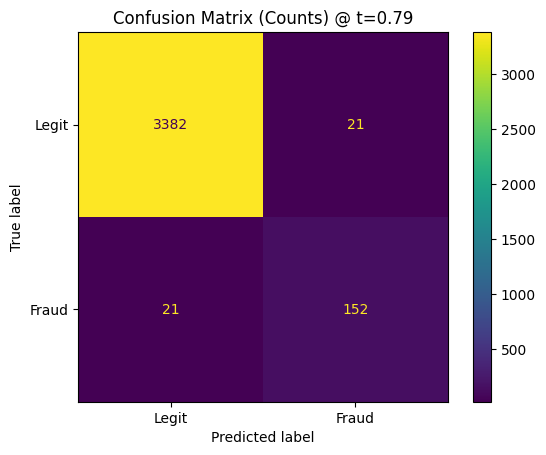

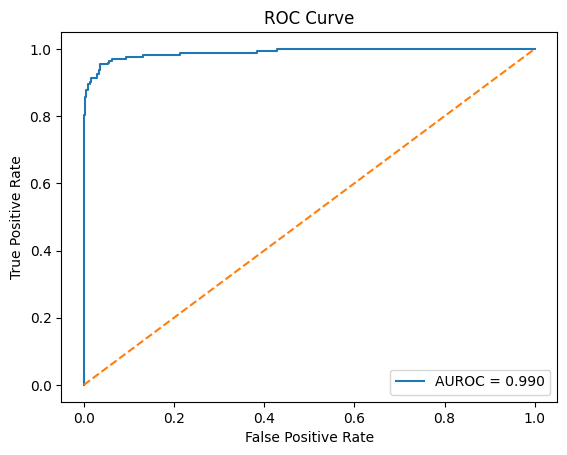

In [22]:

# === Post-training: Confusion Matrix & ROC (at best threshold) ===
# Evaluate one more time using the saved best threshold
state = torch.load(BEST_PATH, map_location="cpu")
best_t = float(state["best_threshold"])

tuned_eval = evaluate(model, val_loader, threshold=best_t)

# Confusion matrix (counts)
cm = confusion_matrix(tuned_eval["labels"], (tuned_eval["probs"] >= best_t).astype(int), labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legit","Fraud"])
disp.plot(values_format="d")
plt.title(f"Confusion Matrix (Counts) @ t={best_t:.2f}")
plt.show()

# ROC curve
fpr, tpr, thr = roc_curve(tuned_eval["labels"], tuned_eval["probs"])
auroc = roc_auc_score(tuned_eval["labels"], tuned_eval["probs"])
plt.figure()
plt.plot(fpr, tpr, label=f"AUROC = {auroc:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [23]:

# === Inference helper: rebuild tabular features exactly like training ===
def build_inference_tab(df_new, bin_cols_saved, num_cols_saved, cat_dummy_cols, tab_feature_names, std_scaler):
    df_feat = df_new.copy()

    # engineered lengths
    for col in TEXT_COLS:
        if col in df_feat.columns:
            df_feat[f"len_{col}"] = df_feat[col].apply(lambda s: len(s) if isinstance(s, str) else 0)

    # location -> country
    if "location" in df_feat.columns:
        def extract_country(x):
            if not isinstance(x, str): return "unknown"
            parts = [p.strip() for p in x.split(",") if p.strip()]
            return parts[-1].lower() if parts else "unknown"
        df_feat["location_country"] = df_feat["location"].apply(extract_country)

    # binaries
    for c in bin_cols_saved:
        df_feat[c] = df_feat.get(c, 0).fillna(0).astype(int)

    # numerics -> scale
    X_num = df_feat.reindex(columns=num_cols_saved, fill_value=0)
    X_num_scaled = pd.DataFrame(std_scaler.transform(X_num.values),
                                columns=num_cols_saved, index=X_num.index)

    # categoricals -> dummies aligned to TRAIN
    cat_base_cols = sorted(set(c.split("_")[0] for c in cat_dummy_cols))
    X_cat = pd.get_dummies(
        df_feat.reindex(columns=cat_base_cols, fill_value="unknown").astype(str),
        drop_first=False
    )
    X_cat = X_cat.reindex(columns=cat_dummy_cols, fill_value=0)

    # final concat in same order
    X_bin = df_feat.reindex(columns=bin_cols_saved, fill_value=0)
    X_tab = pd.concat([X_bin, X_num_scaled, X_cat], axis=1).reindex(columns=tab_feature_names, fill_value=0)
    return X_tab.to_numpy(dtype=np.float32)

# Example usage (provide df_new with text columns + needed tabular columns):
# state = torch.load(BEST_PATH, map_location="cpu")
# tokenizer = AutoTokenizer.from_pretrained(state["tokenizer_name"])
# model = TextTabModel(enc_name=state["encoder_name"], d_tab=len(state["tab_feature_names"]), num_labels=2)
# model.load_state_dict(state["model_state"]); model.eval()
# std_scaler = pickle.loads(state["scaler_bytes"])
# x_tab_new = build_inference_tab(df_new, state["bin_cols"], state["num_cols"], state["cat_dummy_columns"], state["tab_feature_names"], std_scaler)
# Then tokenize df_new["__text__"] similarly and call model(..., x_tab=x_tab_new)


isolated comparison with ooold man machine

In [24]:
@torch.no_grad()
def eval_with_tab_mask(model, loader, threshold, zero_tab=False):
    model.eval()
    from sklearn.metrics import f1_score
    probs, labels = [], []
    for b in loader:
        x_tab = b["x_tab"].to(device)
        if zero_tab: x_tab = torch.zeros_like(x_tab)
        logits = model(
            input_ids=b["input_ids"].to(device),
            attention_mask=b["attention_mask"].to(device),
            x_tab=x_tab
        )
        p = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
        probs.extend(p); labels.extend(b["labels"].numpy())
    import numpy as np
    probs = np.asarray(probs); labels = np.asarray(labels)
    preds = (probs >= threshold).astype(int)
    return f1_score(labels, preds, pos_label=1)

t_star = 0.79  # your epoch-4 best
f1_fusion  = eval_with_tab_mask(model, val_loader, t_star, zero_tab=False)
f1_no_tab  = eval_with_tab_mask(model, val_loader, t_star, zero_tab=True)
print(f"F1_fraud @t*={t_star:.2f}: fusion={f1_fusion:.4f} | no-tab={f1_no_tab:.4f} | Δ={f1_fusion - f1_no_tab:.4f}")


F1_fraud @t*=0.79: fusion=0.8786 | no-tab=0.8786 | Δ=0.0000
